# Neural Networks and Deep Learning - Homework 1: Supervised Deep Learning
## Rosset Lorenzo, mat. 2021859

In [1]:
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 1

Cloning into 'NNDL'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 30 (delta 4), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.
/content/NNDL/Homework 1


In [2]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

# Regression Task

The goal of this section is to train a neural network to approximate an unknown function

$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$

Training points are noisy measures from the target distribution
$$
\hat{y} = f(x) + noise
$$

## Dataset and Dataloader

In [3]:
train_data = pd.read_csv('regression_dataset/train_data.csv')
test_data = pd.read_csv('regression_dataset/test_data.csv')

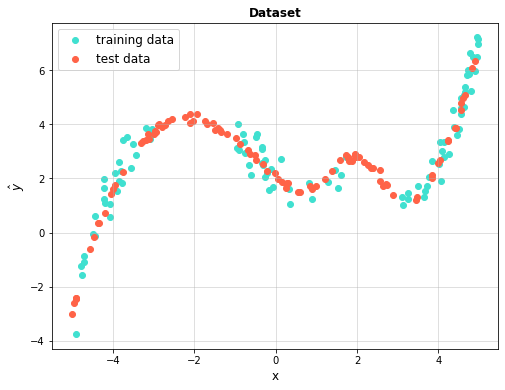

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(train_data.input, train_data.label, color='turquoise', label='training data')
plt.scatter(test_data.input, test_data.label, color='tomato', label='test data')
plt.xlabel('x', size=12)
plt.ylabel(r'$\hat{y}$', size=12)
plt.title('Dataset', size=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.5);

In [5]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [6]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

print('Number of items in the training set:', train_dataset.__len__())
print('Number of items in the test set:', test_dataset.__len__())

Number of items in the training set: 100
Number of items in the test set: 100


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

Since the number of samples in the training set is quite small, a good idea is to evaluate the model's performaces using the cross-validation strategy

## Basic Regression Task

### Network definition

In [8]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [9]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [10]:
# Initialize the network
torch.manual_seed(1)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
torch.save(net.state_dict(), 'reg_base_model.pt')
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [11]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

### Training Loop

In [ ]:
### TRAINING LOOP
num_epochs = 1500
train_loss_log = []
test_loss_log = []
for epoch_num in range(num_epochs):
    print('######################')
    print(f'# EPOCH {epoch_num}')

    ### TRAIN
    train_loss = []
    net.train() # Training mode
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### TEST
    test_loss= []
    net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in test_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            test_loss.append(loss_batch)

        # Save average validation loss
        test_loss = np.mean(test_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(test_loss)}")
        test_loss_log.append(test_loss)

Streaming output truncated to the last 5000 lines.
######################
# EPOCH 250
AVERAGE TRAIN LOSS: 0.32655465602874756
AVERAGE VAL LOSS: 0.32629039883613586
######################
# EPOCH 251
AVERAGE TRAIN LOSS: 0.30228376388549805
AVERAGE VAL LOSS: 0.28054720163345337
######################
# EPOCH 252
AVERAGE TRAIN LOSS: 0.27255746722221375
AVERAGE VAL LOSS: 0.25952503085136414
######################
# EPOCH 253
AVERAGE TRAIN LOSS: 0.3099431097507477
AVERAGE VAL LOSS: 0.2783558964729309
######################
# EPOCH 254
AVERAGE TRAIN LOSS: 0.2988077402114868
AVERAGE VAL LOSS: 0.30006319284439087
######################
# EPOCH 255
AVERAGE TRAIN LOSS: 0.3021257519721985
AVERAGE VAL LOSS: 0.369465708732605
######################
# EPOCH 256
AVERAGE TRAIN LOSS: 0.3296736478805542
AVERAGE VAL LOSS: 0.3032863140106201
######################
# EPOCH 257
AVERAGE TRAIN LOSS: 0.26575183868408203
AVERAGE VAL LOSS: 0.2835160791873932
######################
# EPOCH 258
AVERAGE TRAIN LOSS:

### Plot Losses

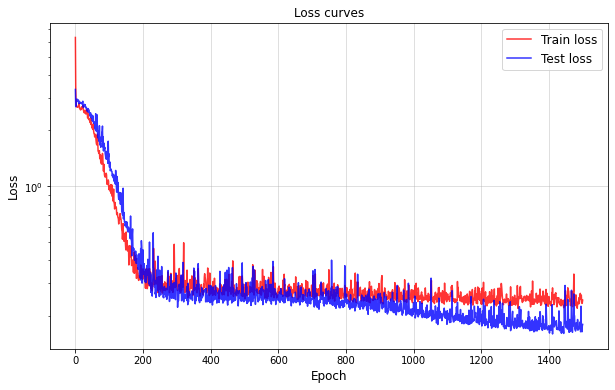

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(test_loss_log, c='blue', label='Test loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

The fact that the test loss is smaller than the train loss can be explained by noting that training data are more spread around than test data, while the average is the same

### Results

In [ ]:
x_vec = torch.linspace(-5, 5, 200).to(device).unsqueeze(-1)
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)
    
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

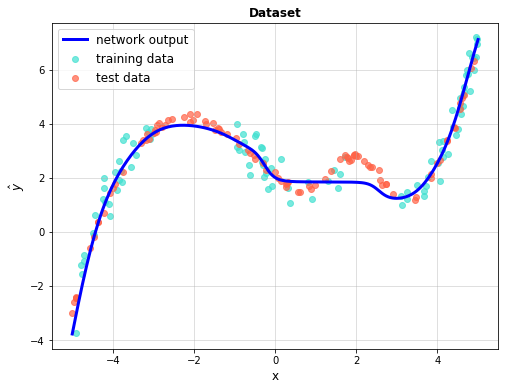

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(train_data.input, train_data.label, color='turquoise', label='training data', alpha=0.7)
plt.scatter(test_data.input, test_data.label, color='tomato', label='test data', alpha=0.7)
plt.plot(x_vec, y_vec, c='blue', label='network output', lw=3)
plt.xlabel('x', size=12)
plt.ylabel(r'$\hat{y}$', size=12)
plt.title('Dataset', size=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.5);

## Advanced Optimizers and Regularization Methods

In this section we are going to use the test set in order to evaluate the generaization capabilities of models with different architectures or being trained with different optimizers. Since we lack a validation set, we can use the cross-validation strategy on the training set in order to select the best model/optimizer and, eventually, evaluate the performances of each model on the test set.

### Different optimizers

We can test the performances of some of the most common optimizars: Adam, Adadelta, Adagrad, RMSprop

In [12]:
def reset_weights(net):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss = []
    model.train()
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = model(x_batch)
        loss = loss_fn(out, label_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch(model, device, dataloader, loss_fn):
    val_loss = []
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)

def train_model(model, num_folds, num_epochs, batch_size, device, train_dataset, test_dataset, loss_fn, optimizer):
    test_dataloader = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)
    train_loss_log = []
    val_loss_log = []
    test_loss_log = []
    splits = KFold(n_splits=num_folds, shuffle=True, random_state=2022)
    for fold, (train_idx, val_idx) in enumerate(splits.split(train_dataset)):
        print(f'\nFold {fold+1}\n')
        model.apply(reset_weights) # Reset the network
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
        history = {'train_loss' : [], 'val_loss' : []}

        for epoch in range(num_epochs):
            train_loss = train_epoch(model, device, train_loader, loss_fn, optimizer)
            val_loss = val_epoch(model, device, val_loader, loss_fn)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            print("Epoch:{}/{}, AVG Training Loss:{:.3f}, AVG Val Loss:{:.3f}".format(epoch + 1, num_epochs, train_loss, val_loss))
        train_loss_log.append(history['train_loss'])
        val_loss_log.append(history['val_loss'])

        # Evaluate the trained model on the test set
        test_loss = val_epoch(model, device, test_dataloader, loss_fn)
        test_loss_log.append(test_loss)

    avg_train_loss = np.mean(train_loss_log, axis=0)
    avg_val_loss = np.mean(val_loss_log, axis=0)
    avg_test_loss = np.mean(test_loss_log)
    return avg_train_loss, avg_val_loss, avg_test_loss

In [ ]:
models = [Net(Ni, Nh1, Nh2, No),
          Net(Ni, Nh1, Nh2, No),
          Net(Ni, Nh1, Nh2, No),
          Net(Ni, Nh1, Nh2, No)]
for model in models:
    model.to(device)
lab_optimizers = ['Adam', 'Adagrad', 'Adadelta', 'RMSprop']
optimizers = [optim.Adam(models[0].parameters(), lr=1e-3),
              optim.Adadelta(models[1].parameters(), lr=1e-3),
              optim.Adagrad(models[2].parameters(), lr=1e-3),
              optim.RMSprop(models[3].parameters(), lr=1e-3)]
train_curves = []
val_curves = []
test_losses = []
for label, model, optimizer in zip(lab_optimizers, models, optimizers):
    print('\n---------------------------')
    print('Optimizer:', label)
    print('---------------------------\n')
    avg_train_loss, avg_val_loss, avg_test_loss = train_model(model, 5, 500, 10, device, train_dataset, test_dataset, loss_fn, optimizer)
    train_curves.append(avg_train_loss)
    val_curves.append(avg_val_loss)
    test_losses.append(avg_test_loss)

Streaming output truncated to the last 5000 lines.
Epoch:33/500, AVG Training Loss:2.999, AVG Val Loss:2.228
Epoch:34/500, AVG Training Loss:2.987, AVG Val Loss:2.230
Epoch:35/500, AVG Training Loss:2.973, AVG Val Loss:2.233
Epoch:36/500, AVG Training Loss:2.966, AVG Val Loss:2.235
Epoch:37/500, AVG Training Loss:2.953, AVG Val Loss:2.240
Epoch:38/500, AVG Training Loss:2.942, AVG Val Loss:2.243
Epoch:39/500, AVG Training Loss:2.938, AVG Val Loss:2.248
Epoch:40/500, AVG Training Loss:2.929, AVG Val Loss:2.250
Epoch:41/500, AVG Training Loss:2.919, AVG Val Loss:2.253
Epoch:42/500, AVG Training Loss:2.914, AVG Val Loss:2.256
Epoch:43/500, AVG Training Loss:2.910, AVG Val Loss:2.260
Epoch:44/500, AVG Training Loss:2.896, AVG Val Loss:2.263
Epoch:45/500, AVG Training Loss:2.888, AVG Val Loss:2.267
Epoch:46/500, AVG Training Loss:2.881, AVG Val Loss:2.271
Epoch:47/500, AVG Training Loss:2.876, AVG Val Loss:2.275
Epoch:48/500, AVG Training Loss:2.873, AVG Val Loss:2.278
Epoch:49/500, AVG Tra

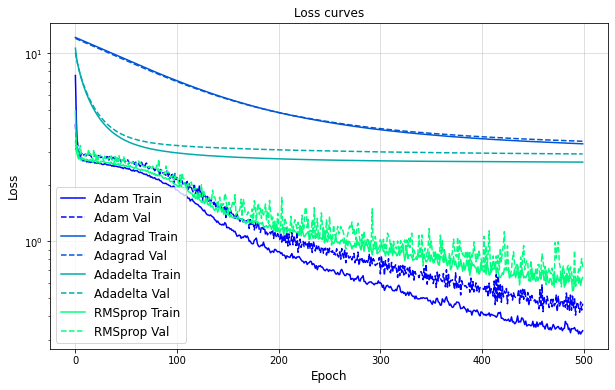

In [ ]:
# Visualization of training curves
colors = cm.get_cmap('winter', len(lab_optimizers))
plt.figure(figsize=(10,6))
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

for i, (train_curve, val_curve, label) in enumerate(zip(train_curves, val_curves, lab_optimizers)):
    plt.plot(train_curve, c=colors(i), label=label + ' Train')
    plt.plot(val_curve, c=colors(i), ls='--', label=label + ' Val')

plt.legend(fontsize='12');

Adam test loss: 0.48734742


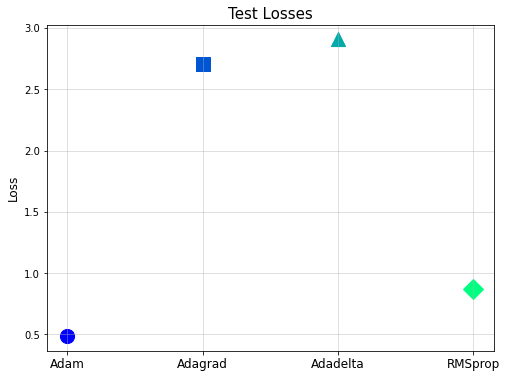

In [ ]:
# Visualization of performaces on the test set
plt.figure(figsize=(8,6))
plt.ylabel('Loss', size=12)
plt.title('Test Losses', size=15)
plt.grid(axis='both', alpha=0.5)
markers = ['o', 's', '^', 'D']

for i in range(len(lab_optimizers)):
    plt.scatter([i], [test_losses[i]], s=200, color=colors(i), marker=markers[i])

plt.xticks(ticks=[0,1,2,3], labels=lab_optimizers, rotation=0, size=12);
print('Adam test loss:', test_losses[0])

### Regularization methods

Some regularization methods include weight decay (L2) and Dropout. We can compare the performances on the test set without any regularization, with only weight regularization, with only dropout and with both regularization and dropout

In [13]:
class Net_reg(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.dropout = nn.Dropout(p=0.2)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [15]:
# Initialize the network
torch.manual_seed(1)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1

# Define the loss function
loss_fn = nn.MSELoss()

In [16]:
net1 = Net(Ni, Nh1, Nh2, No)
net1.to(device)

# Define the optimizer
optimizer = optim.Adam(net1.parameters(), lr=1e-3)

### Training loop
num_epochs = 1000
train_loss_log1 = []
test_loss_log1 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net1, device, train_dataloader, loss_fn, optimizer)
    train_loss_log1.append(train_loss)

    test_loss = val_epoch(net1, device, test_dataloader, loss_fn)
    test_loss_log1.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 6.340, test loss: 3.326
Epoch 1, train loss: 3.438, test loss: 2.685
Epoch 2, train loss: 2.835, test loss: 2.814
Epoch 3, train loss: 2.705, test loss: 2.904
Epoch 4, train loss: 2.684, test loss: 2.945
Epoch 5, train loss: 2.667, test loss: 2.949
Epoch 6, train loss: 2.691, test loss: 2.930
Epoch 7, train loss: 2.679, test loss: 2.885
Epoch 8, train loss: 2.702, test loss: 2.862
Epoch 9, train loss: 2.698, test loss: 2.917
Epoch 10, train loss: 2.689, test loss: 2.787
Epoch 11, train loss: 2.789, test loss: 2.831
Epoch 12, train loss: 2.637, test loss: 2.865
Epoch 13, train loss: 2.632, test loss: 2.847
Epoch 14, train loss: 2.603, test loss: 2.814
Epoch 15, train loss: 2.581, test loss: 2.822
Epoch 16, train loss: 2.617, test loss: 2.821
Epoch 17, train loss: 2.592, test loss: 2.797
Epoch 18, train loss: 2.676, test loss: 2.824
Epoch 19, train loss: 2.627, test loss: 2.797
Epoch 20, train loss: 2.620, test loss: 2.770
Epoch 21, train loss: 2.

In [23]:
net2 = Net(Ni, Nh1, Nh2, No)
net2.to(device)

# Define the optimizer
optimizer = optim.Adam(net2.parameters(), lr=1e-3, weight_decay=0.002)

### Training loop
num_epochs = 1000
train_loss_log2 = []
test_loss_log2 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net2, device, train_dataloader, loss_fn, optimizer)
    train_loss_log2.append(train_loss)

    test_loss = val_epoch(net2, device, test_dataloader, loss_fn)
    test_loss_log2.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 5.900, test loss: 3.047
Epoch 1, train loss: 3.341, test loss: 2.745
Epoch 2, train loss: 2.802, test loss: 2.881
Epoch 3, train loss: 2.763, test loss: 2.853
Epoch 4, train loss: 2.687, test loss: 2.919
Epoch 5, train loss: 2.672, test loss: 2.905
Epoch 6, train loss: 2.657, test loss: 2.882
Epoch 7, train loss: 2.700, test loss: 2.918
Epoch 8, train loss: 2.660, test loss: 2.765
Epoch 9, train loss: 2.842, test loss: 2.919
Epoch 10, train loss: 2.614, test loss: 2.857
Epoch 11, train loss: 2.620, test loss: 2.836
Epoch 12, train loss: 2.625, test loss: 2.776
Epoch 13, train loss: 2.674, test loss: 2.820
Epoch 14, train loss: 2.619, test loss: 2.796
Epoch 15, train loss: 2.631, test loss: 2.816
Epoch 16, train loss: 2.618, test loss: 2.783
Epoch 17, train loss: 2.590, test loss: 2.778
Epoch 18, train loss: 2.595, test loss: 2.787
Epoch 19, train loss: 2.635, test loss: 2.758
Epoch 20, train loss: 2.596, test loss: 2.776
Epoch 21, train loss: 2.

In [18]:
net3 = Net_reg(Ni, Nh1, Nh2, No)
net3.to(device)

# Define the optimizer
optimizer = optim.Adam(net3.parameters(), lr=1e-3)

### Training loop
num_epochs = 1000
train_loss_log3 = []
test_loss_log3 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net3, device, train_dataloader, loss_fn, optimizer)
    train_loss_log3.append(train_loss)

    test_loss = val_epoch(net3, device, test_dataloader, loss_fn)
    test_loss_log3.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 3.772, test loss: 3.364
Epoch 1, train loss: 3.041, test loss: 2.788
Epoch 2, train loss: 2.842, test loss: 3.007
Epoch 3, train loss: 2.780, test loss: 3.021
Epoch 4, train loss: 2.851, test loss: 2.983
Epoch 5, train loss: 2.937, test loss: 2.845
Epoch 6, train loss: 2.906, test loss: 2.871
Epoch 7, train loss: 2.666, test loss: 2.858
Epoch 8, train loss: 2.728, test loss: 2.836
Epoch 9, train loss: 2.730, test loss: 2.875
Epoch 10, train loss: 2.706, test loss: 2.845
Epoch 11, train loss: 2.666, test loss: 2.837
Epoch 12, train loss: 2.546, test loss: 2.869
Epoch 13, train loss: 2.666, test loss: 2.830
Epoch 14, train loss: 2.672, test loss: 2.863
Epoch 15, train loss: 2.701, test loss: 2.853
Epoch 16, train loss: 2.776, test loss: 2.779
Epoch 17, train loss: 2.720, test loss: 2.778
Epoch 18, train loss: 2.622, test loss: 2.829
Epoch 19, train loss: 2.580, test loss: 2.735
Epoch 20, train loss: 2.671, test loss: 2.787
Epoch 21, train loss: 2.

In [21]:
net4 = Net_reg(Ni, Nh1, Nh2, No)
net4.to(device)

# Define the optimizer
optimizer = optim.Adam(net4.parameters(), lr=1e-3, weight_decay=0.002)

### Training loop
num_epochs = 1000
train_loss_log4 = []
test_loss_log4 = []
for epoch_num in range(num_epochs):

    train_loss = train_epoch(net4, device, train_dataloader, loss_fn, optimizer)
    train_loss_log4.append(train_loss)

    test_loss = val_epoch(net4, device, test_dataloader, loss_fn)
    test_loss_log4.append(test_loss)

    print('Epoch {:}, train loss: {:.3f}, test loss: {:.3f}'.format(epoch_num, train_loss, test_loss))

Network initialized
Epoch 0, train loss: 5.052, test loss: 3.049
Epoch 1, train loss: 3.137, test loss: 2.771
Epoch 2, train loss: 2.707, test loss: 2.867
Epoch 3, train loss: 2.779, test loss: 2.888
Epoch 4, train loss: 2.702, test loss: 2.902
Epoch 5, train loss: 2.637, test loss: 2.921
Epoch 6, train loss: 2.758, test loss: 2.920
Epoch 7, train loss: 2.592, test loss: 2.914
Epoch 8, train loss: 2.607, test loss: 2.838
Epoch 9, train loss: 2.692, test loss: 2.823
Epoch 10, train loss: 2.698, test loss: 2.753
Epoch 11, train loss: 3.039, test loss: 2.911
Epoch 12, train loss: 2.652, test loss: 2.905
Epoch 13, train loss: 2.567, test loss: 2.901
Epoch 14, train loss: 2.717, test loss: 2.778
Epoch 15, train loss: 2.823, test loss: 2.750
Epoch 16, train loss: 2.676, test loss: 2.823
Epoch 17, train loss: 2.821, test loss: 2.810
Epoch 18, train loss: 2.729, test loss: 2.790
Epoch 19, train loss: 2.617, test loss: 2.767
Epoch 20, train loss: 2.545, test loss: 2.789
Epoch 21, train loss: 2.

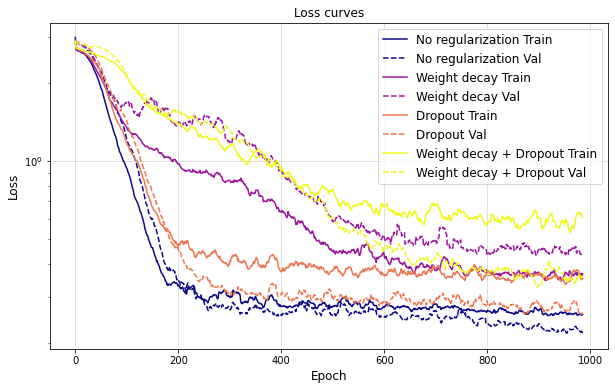

In [32]:
def sliding_average(arr, l):
    return np.convolve(arr, np.ones(l)/l, mode='valid')

# Visualization of training curves
train_loss_logs = [sliding_average(arr, 15) for arr in [train_loss_log1, train_loss_log2, train_loss_log3, train_loss_log4]]
test_loss_logs = [sliding_average(arr, 15) for arr in [test_loss_log1, test_loss_log2, test_loss_log3, test_loss_log4]]
labels = ['No regularization', 'Weight decay', 'Dropout', 'Weight decay + Dropout']

colors = cm.get_cmap('plasma', 4)
plt.figure(figsize=(10,6))
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
plt.yscale('log')

for i, (train_curve, test_curve, label) in enumerate(zip(train_loss_logs, test_loss_logs, labels)):
    plt.plot(train_curve, c=colors(i), label=label + ' Train')
    plt.plot(test_curve, c=colors(i), ls='--', label=label + ' Val')

plt.legend(fontsize='12');

The data distribution is simple and thare are a lot of points along the curve, so there is "no danger of overfitting"